In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import sksurv.datasets
from sklearn_pandas import DataFrameMapper

import torch
import torchtuples as tt

from pycox.models import CoxPH
from pycox.evaluation import EvalSurv

In [2]:
np.random.seed(1234)
_ = torch.manual_seed(123)

In [3]:
df = pd.read_csv('../../data/gcp_3.csv')
df.set_index(keys = 'TRR_ID_CODE', inplace = True)

In [4]:
df_train = df
df_test = df_train.sample(frac = 0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac = 0.2)
df_train = df_train.drop(df_val.index)


In [5]:
# Feature transforms

# Used features 0-25 from weights

cols_standardize = ['AGE_DON', 'AGE', 'INIT_AGE', 'COLD_ISCH_KI',
                    'Transplant_Year', 'BUN_DON', 'DISTANCE', 'PO2_DON',
                   'CREAT_TRR', 'CREAT_DON', 'BMI_CALC', 'HEMATOCRIT_DON']

cols_leave = ['ECD_DONOR', 'HIST_HYPERTENS_DON', 'URINE_INF_DON',
              'DRMIS_2.0', 'HIST_CIG_DON', 'HTLV_DON_ND', 'REGION_2',
             'RDR1_4.0', 'DIABETES_DON', 'INOTROP_SUPPORT_DON', 'EBV_SEROSTATUS_P',
             'DEATH_MECH_DON_3', 'DR1_4', 'HIST_OTH_DRUG_DON']


standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [6]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')


In [7]:
get_target = lambda df: (df['GTIME_KI_YEARS'].values, df['GRF_STAT_NUM'].values)
y_train = get_target(df_train)
y_val = get_target(df_val)
durations_test, events_test = get_target(df_test)
val = x_val, y_val


### Neural net

In [8]:
n_nodes = 256
in_features = x_train.shape[1]
num_nodes = [n_nodes, n_nodes, n_nodes, n_nodes]
out_features = 1
batch_norm = True
dropout = 0.4
output_bias = False

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout, output_bias=output_bias)


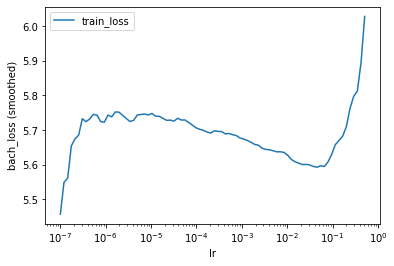

In [9]:
model = CoxPH(net, tt.optim.Adam)


batch_size = 500
lrfinder = model.lr_finder(x_train, y_train, batch_size, tolerance=10)
_ = lrfinder.plot()




In [10]:
best = lrfinder.get_best_lr()


In [11]:
model.optimizer.set_lr(best)
model.optimizer.param_groups[0]['lr']


0.0001

In [12]:
epochs = 512
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True


In [13]:
%%time
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val, val_batch_size=batch_size)


0:	[10s / 10s],		train_loss: 5.5854,	val_loss: 5.3295
1:	[10s / 21s],		train_loss: 5.4946,	val_loss: 5.3164
2:	[6s / 28s],		train_loss: 5.4530,	val_loss: 5.3096
3:	[7s / 35s],		train_loss: 5.4244,	val_loss: 5.3065
4:	[7s / 42s],		train_loss: 5.4141,	val_loss: 5.3038
5:	[6s / 49s],		train_loss: 5.4030,	val_loss: 5.3024
6:	[6s / 55s],		train_loss: 5.3938,	val_loss: 5.3008
7:	[8s / 1m:3s],		train_loss: 5.3735,	val_loss: 5.2971
8:	[9s / 1m:12s],		train_loss: 5.3619,	val_loss: 5.2959
9:	[6s / 1m:19s],		train_loss: 5.3642,	val_loss: 5.2956
10:	[6s / 1m:26s],		train_loss: 5.3448,	val_loss: 5.2940
11:	[6s / 1m:33s],		train_loss: 5.3447,	val_loss: 5.2928
12:	[6s / 1m:40s],		train_loss: 5.3495,	val_loss: 5.2919
13:	[6s / 1m:47s],		train_loss: 5.3362,	val_loss: 5.2917
14:	[7s / 1m:54s],		train_loss: 5.3418,	val_loss: 5.2911
15:	[8s / 2m:2s],		train_loss: 5.3284,	val_loss: 5.2900
16:	[9s / 2m:11s],		train_loss: 5.3173,	val_loss: 5.2895
17:	[8s / 2m:20s],		train_loss: 5.3198,	val_loss: 5.2885
18:	[

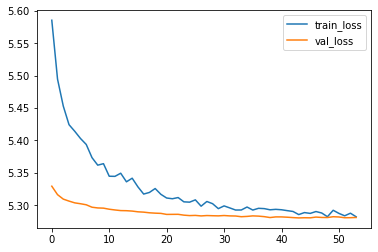

In [14]:

_ = log.plot()


### Prediction

In [15]:
_ = model.compute_baseline_hazards()


In [16]:
surv = model.predict_surv_df(x_test)


### Evaluation

In [17]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [18]:
ev.concordance_td()


0.6354303186849679

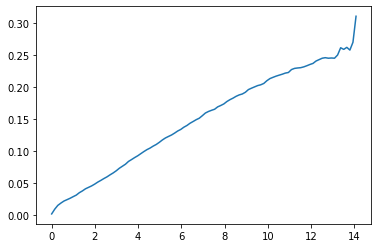

In [19]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
_ = ev.brier_score(time_grid).plot()

In [20]:
# Integrated Brier Score at 10 years
time_grid = np.linspace(durations_test.min(), durations_test.max(), 10)
ev.integrated_brier_score(time_grid)

0.15051762162837312

In [21]:
#Integrated brier score at 5 years
time_grid = np.linspace(durations_test.min(), 5, 100)
ev.integrated_brier_score(time_grid)

0.060387219336820584

In [22]:
#The integrated IPCW (negative) binomial log-likelihood. Numerical integration of the `nbll` at 10 years
time_grid = np.linspace(durations_test.min(), 10, 100)
ev.integrated_nbll(time_grid)

0.3678686617023344

In [23]:
# The integrated IPCW (negative) binomial log-likelihood. Numerical integration of the `nbll`at 5 years
time_grid = np.linspace(durations_test.min(), 5, 100)
ev.integrated_nbll(time_grid)

0.2291222058691968